# Notebook d'exploration SQL Stack
## Adrian Rodriguez
## Projet 5 parcours Ingénieur Machine Learning
Accès projet git : https://github.com/Adrian1903/Categorisez-automatiquement-des-questions   
Plus d'informations : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning

---
# 0. Contexte

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Les données
Stack Overflow propose un outil d’export de données - "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

Contraintes :
- Mettre en œuvre une approche non supervisée.
- Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
- Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
- Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
- Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

Le but de ce notebook est d'explorer la structure de la base de la base de posts de Stack. L'objectif final est d'obtenir une requête optimale pour la phase de nettoyage. Le requête de base sera généraliste pour être affiné précisément à la fin de ce notebook.

In [23]:
import pandas as pd
pd.options.display.max_columns = None
from IPython.display import Image

---
# 1. Importation et exploration préliminaire
Les données ont été extraite du site stackexchangeexplorer avec une requête généraliste. J'ai traité des post récents, avec un minimum de maturité, laissant aux utilisateurs finaux d'apporter suffisement d'élements à la question.    
Requête SQL de base : 
```
DECLARE @max_date as DATETIME = DATEADD(MONTH, -1, GETDATE())

SELECT TOP 1000 *    
FROM posts
WHERE CreationDate < @max_date
ORDER BY CreationDate DESC
```
   
Les données ont été stockées dans le fichier 'QueryResults.csv'.

In [4]:
stack_raw = pd.read_csv('src/QueryResults.csv')

In [5]:
stack_raw.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
0,63091317,1,63091512.0,NaN,2020-07-25 17:22:38,NaN,0,50.0,<p>I would like to add on a input a thousand s...,10823960.0,NaN,10823960.0,NaN,2020-07-25 19:47:52,2020-07-25 19:47:52,Thousand separator input with React Hooks,<javascript><reactjs><input><react-hooks>,1.0,1,2.0,NaN,NaN,CC BY-SA 4.0
1,63091316,2,NaN,52295117.0,2020-07-25 17:22:34,NaN,0,NaN,<p>I was not able to solve this problem but I ...,12891283.0,NaN,NaN,NaN,NaN,2020-07-25 17:22:34,NaN,NaN,NaN,0,NaN,NaN,NaN,CC BY-SA 4.0
2,63091314,1,NaN,NaN,2020-07-25 17:22:20,NaN,0,41.0,<p>I'm having some trouble using ABySS to asse...,13470135.0,NaN,NaN,NaN,NaN,2020-07-26 00:17:29,Error while using ABySS to assemble SRA sequence,<linux><makefile><bioinformatics><dna-sequence...,1.0,0,NaN,NaN,NaN,CC BY-SA 4.0
3,63091312,1,63091404.0,NaN,2020-07-25 17:22:17,NaN,-1,59.0,<p>how can I run the for loop for &quot;n&quot...,8621683.0,NaN,1936824.0,NaN,2020-07-26 00:21:09,2020-07-26 00:21:09,how can I run the for loop for m number of tim...,<python>,1.0,2,NaN,NaN,NaN,CC BY-SA 4.0
4,63091311,1,NaN,NaN,2020-07-25 17:22:10,NaN,0,14.0,<p>I have tried for a few hours to get a JSON ...,11109968.0,NaN,NaN,NaN,NaN,2020-07-25 18:44:14,Kairos json to firebase database - Object of t...,<python><firebase><firebase-realtime-database>...,1.0,0,NaN,NaN,NaN,CC BY-SA 4.0


In [6]:
stack_raw.shape

(10000, 23)

In [7]:
stack_raw.columns

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
       'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
       'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate',
       'ContentLicense'],
      dtype='object')

In [8]:
stack_raw.isna().sum()

Id                           0
PostTypeId                   0
AcceptedAnswerId          8432
ParentId                  4824
CreationDate                 0
DeletionDate             10000
Score                        0
ViewCount                 5190
Body                         5
OwnerUserId                 30
OwnerDisplayName          9965
LastEditorUserId          6307
LastEditorDisplayName     9993
LastEditDate              6300
LastActivityDate             0
Title                     5190
Tags                      5190
AnswerCount               5190
CommentCount                 0
FavoriteCount             9683
ClosedDate                9724
CommunityOwnedDate        9990
ContentLicense               0
dtype: int64

In [9]:
stack = stack_raw.copy()

---
# 2. Ajout des conditions
## 2-1. Identification des types de posts

In [10]:
stack.PostTypeId.value_counts()

2    5176
1    4810
5       7
4       7
Name: PostTypeId, dtype: int64

In [11]:
columns = ['Id', 'Title', 'Tags']
for i in range(1, 6):
    PostId = stack.PostTypeId == i
    print(f'Type de posts : {i}')
    display(stack[PostId][columns].notna().sum())

Type de posts : 1


Id       4810
Title    4810
Tags     4810
dtype: int64

Type de posts : 2


Id       5176
Title       0
Tags        0
dtype: int64

Type de posts : 3


Id       0
Title    0
Tags     0
dtype: int64

Type de posts : 4


Id       7
Title    0
Tags     0
dtype: int64

Type de posts : 5


Id       7
Title    0
Tags     0
dtype: int64

Losque l'on créé un nouveau sujet, l'utilisateur doit indiquer un titre et des tags correpondant à son sujet. Si un post ne contient ni titre, ni tags, alors il s'agit d'un post de réponse à une question.   
De ce fait, si `PostTypeId` = 1  alors il s'agit d'un post de question, un post où je dois suggérer des tags à l'utilisateur final.

Condition de requête :   
``PostTypeId = 1``

In [12]:
questions = stack[stack.PostTypeId == 1]

## 2-2. Compréhension du score
Le site de stack permet a ces utilisateurs finaux de voter la pertinence d'un post, que ce soit pour une question ou pour une réponse. Ce score permet d'évaluer la pertinence du post.

In [15]:
questions.Score.value_counts().sort_index()

-6        1
-5        5
-4       17
-3       37
-2      148
-1      456
 0     3082
 1      764
 2      193
 3       64
 4       21
 5        8
 6        7
 7        2
 8        1
 10       1
 11       2
 61       1
Name: Score, dtype: int64

Je constate des scores négatifs ainsi que des scores positifs. Ce score me permet de faire le tri entre les questions pertinentes, vérifiées par la communauté, et les questions floues, manquant de précisions. L'exemple ci-dessous illustre la cas où un utilisateur émet un pari en réponse à la question.

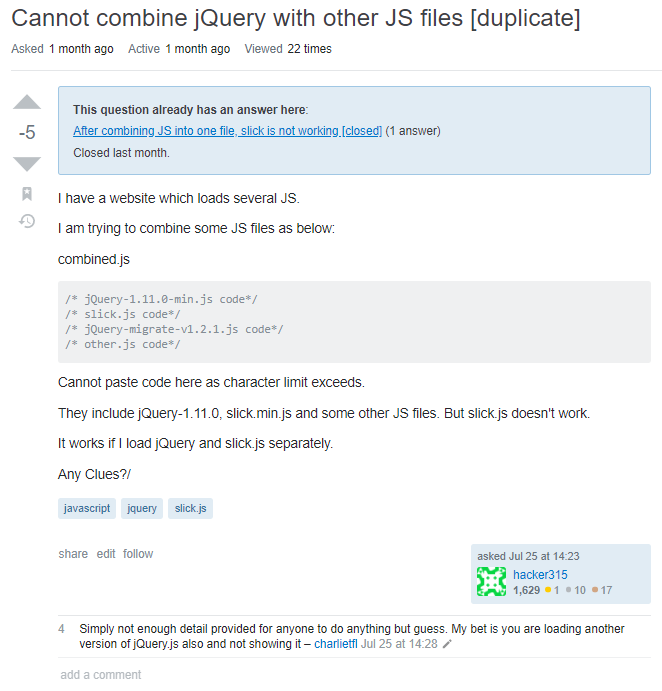

In [24]:
Image('src/bad_post.PNG')

Les utilisateurs pouvant voter ont une réputation d'au moins 15 points, et sont donc des utilisateurs reconnus. Ce score me permet donc de vérifier la solidité de mes questions, car ce qui est flou pour l'utilisateur final ne sera pas de bonne augure pour ma modélisation. Des questions peuvent obtenir des scores de plus 1000 points, c'est assez courant. Je fixe la limite à 20 points minimum.

Condition de requête :
`Score > 19`

## 2-3. Choix des variables

In [32]:
stack.columns

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
       'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
       'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate',
       'ContentLicense'],
      dtype='object')

En prévision du travail à fournir, je ne vais conserver que les variables utiles à la prédictions des tags, à savoir :
- Title,
- Body,
- Tags,

Je garderai aussi l'Id de la question afin de tracer la questions en cas de besoin.

# 3. Quelques chiffres-clés

## 3-1. Activité des utilisateurs finaux du site

In [28]:
stack.CreationDate = pd.to_datetime(stack.CreationDate, format="%Y-%m-%d %H:%M:%S")
delta = stack.CreationDate.max() - stack.CreationDate.min()
delay_post = round(delta.total_seconds() / len(stack), 0)
delay_question = round(delta.total_seconds() / len(questions), 0)
print(f'Le site Stackoverflow recoit un post, que ce soit en question ou en réponse aux questions, toutes les {delay_post} secondes et une nouvelle question toutes les {delay_question} secondes')

Le site Stackoverflow recoit un post, que ce soit en question ou en réponse aux questions, toutes les 8.0 secondes et une nouvelle question toutes les 18.0 secondes


## 3-2. Taux de réponse à une question

In [31]:
no_response = round(questions.AnswerCount.value_counts().loc[0] / len(questions) * 100, 0)
print(f"{no_response} % des questions posées ne trouvent aucune réponse au bout d'1 mois.")

38.0 % des questions posées ne trouvent aucune réponse au bout d'1 mois.


# 4. Requête finale

Rappel des critères de sélections des posts :
- Au moins 1 mois d'ancienneté (afin de laisser de la maturité au questions), les plus récentes en priorité.
- Posts contenant des questions (PostTypeId = 1)
- Posts reconnus fiables par des utilisateurs reconnus (pas de questions incomprises, mal tournée)

```
DECLARE @max_date as DATETIME = DATEADD(MONTH, -1, GETDATE())

SELECT Id, Title, Body, Tags    
FROM posts
WHERE CreationDate < @max_date AND PostTypeId = 1 AND Score > 19
ORDER BY CreationDate DESC
```